# Exercise 5  -  Restricted Boltzman Machines (RBMs)

Guadagnini Michele - 1230663

Lambertini Alessandro - 1242885

Pagano Alice - 1236916

Puppin Michele - 1227474

## 0 - Data Generation

In [1]:
import csv
import random
import numpy as np
from numpy import exp
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
N = 10000 # number of data
C = 4 # possible different cases
Z = 2 # block size
L = C*Z # size of each data point

q = 0.1

y = [0]*N
x = [[0]*L for j in range(N)]
v0 = [0]*Z
v1 = [1]*Z
case = (v1 + v0 + v1 + v0, # Define four cases
        v0 + v1 + v1 + v0,
        v1 + v0 + v0 + v1,
        v0 + v1 + v0 + v1)

for c in range(C):
    print('"', c , '"', *case[c], sep = "")

"0"11001100
"1"00111100
"2"11000011
"3"00110011


In [3]:
random.seed(12345)

for i in range(N): # Introduce noise in generated data by flipping randomly one digit
    y[i] = random.randint(0,3)
    x[i][:] = case[y[i]]
    for j in range(L):
        if random.random()<0.1:
            x[i][j] = 1-x[i][j]
            
for i in range(10):
    print('"', y[i] , '"', *x[i], sep = "")

"3"00110011
"3"00110011
"1"00110100
"3"10110111
"1"00111100
"1"00111100
"2"11000010
"3"10110011
"3"01110011
"0"10001100


In [4]:
fname = 'dataRBM_q'+str(q)+'.csv'
print(fname)

with open (fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    for i in range(N):
        writer.writerow(x[i])

dataRBM_q0.1.csv


In [5]:
fname = 'dataRBM_q0.1.csv'

data = np.loadtxt(fname, delimiter=',', dtype=int)
N = len(data)
L = len(data[1])
print(f'each of N={N} data has L={L} digits')

each of N=10000 data has L=8 digits


In [6]:
v = 2*data - 1 # Convert 0,1 to -1,1 
v0 = np.zeros_like(v)
v0[:] = v[:]
for k in range(10):
    print(data[k],v[k])

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 1 0 0] [-1 -1  1  1 -1  1 -1 -1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[1 1 0 0 0 0 1 0] [ 1  1 -1 -1 -1 -1  1 -1]
[1 0 1 1 0 0 1 1] [ 1 -1  1  1 -1 -1  1  1]
[0 1 1 1 0 0 1 1] [-1  1  1  1 -1 -1  1  1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]


In [7]:
np.random.seed(12342)
M = 2

# Initializing parameters

sigma = np.sqrt(4. / float(L+M)) 

w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

print(w)
print(a)
print(b)

w0, a0, b0 = w, a, b

[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
[0. 0.]


[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


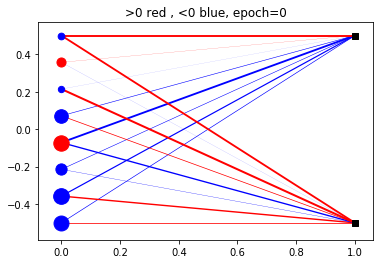

In [8]:
# Defining useful functions for the plot

def create_coord(np,x0):
    x=[x0]*np
    print(x)
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.)-0.5
    return(x,y)

(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)

def mycolor(val):
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(epoch=0):
    A = 2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))

    PS=400.
    PSmin=40
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=max(PSmin,PS*np.abs(a[i])), zorder=2, c=mycolor(a[i]))
    for i in range(M):
        plt.scatter(x2[i], y2[i], s=max(PSmin,PS*np.abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    plt.title(f'>0 red , <0 blue, epoch={epoch}')
    plt.show()

plotgraph()

In [9]:
def activate(v_in, wei, bias, info=False): # Define activation function with sigmoid 
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + exp(-act))
    n = np.shape(act)
    v_out = -np.ones(n, dtype=int)
    v_out[np.random.random_sample(n)<prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('output=', v_out)
    return v_out

k = 0
activate(v[k],w,b,info=True)

input= [-1 -1  1  1 -1 -1  1  1]
act= [-1.4184683   0.61989888]
prob= [0.19490182 0.65019555]
output= [-1  1]


array([-1,  1])

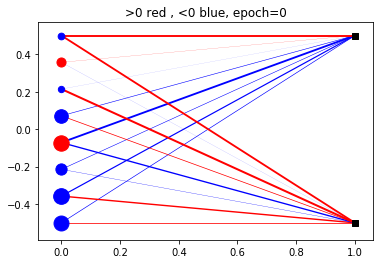

--------- epoch = 1  k= 499  m= 500
dw = [[ 0.296  0.132]
 [ 0.148  0.168]
 [-0.316  0.008]
 [-0.16   0.156]
 [-0.108 -0.208]
 [-0.064 -0.268]
 [ 0.016  0.188]
 [-0.244  0.048]]
da = [ 0.192  0.244  0.164 -0.304  0.284 -0.024 -0.152  0.076]
db = [ 0.16  -0.036]
completed epoch  1  with l_rate=  1.0


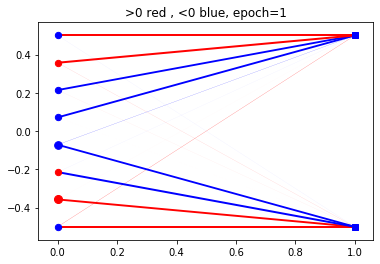

--------- epoch = 2  k= 499  m= 500
dw = [[-0.03666667 -0.06666667]
 [-0.00333333  0.01333333]
 [-0.01333333 -0.01666667]
 [-0.04        0.09      ]
 [ 0.          0.00333333]
 [ 0.01333333 -0.00333333]
 [ 0.02333333  0.02      ]
 [-0.05333333  0.03      ]]
da = [-0.05333333 -0.07333333  0.03        0.01666667  0.02333333  0.03666667
  0.00666667  0.01666667]
db = [-0.02333333  0.00666667]
completed epoch  2  with l_rate=  0.8333333333333334


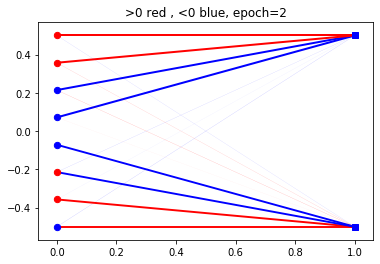

completed epoch  3  with l_rate=  0.7142857142857143


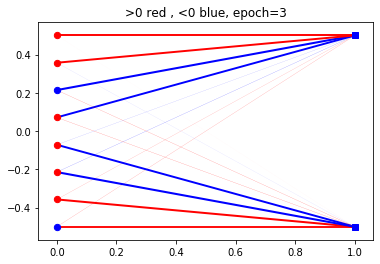

completed epoch  4  with l_rate=  0.625


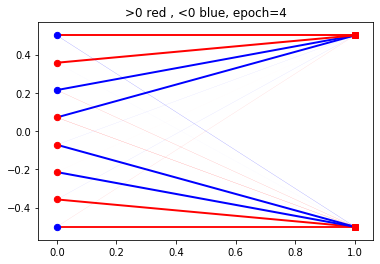

completed epoch  5  with l_rate=  0.5555555555555556


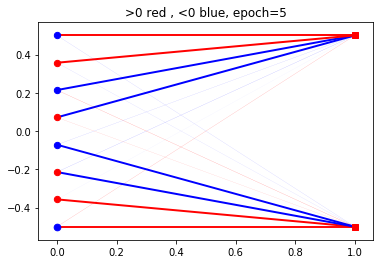

completed epoch  6  with l_rate=  0.5


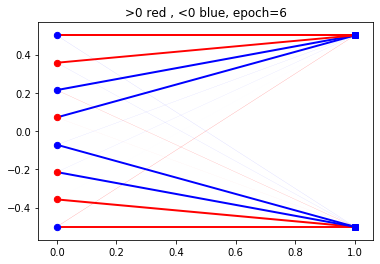

completed epoch  7  with l_rate=  0.45454545454545453


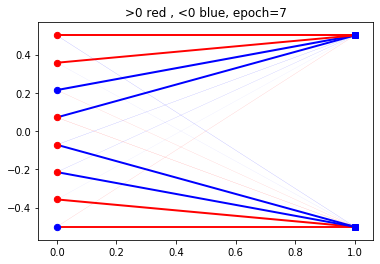

completed epoch  8  with l_rate=  0.4166666666666667


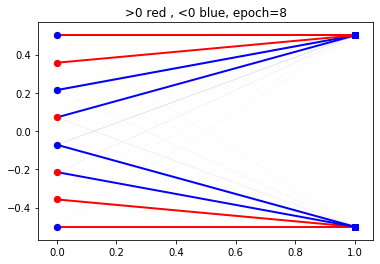

completed epoch  9  with l_rate=  0.38461538461538464


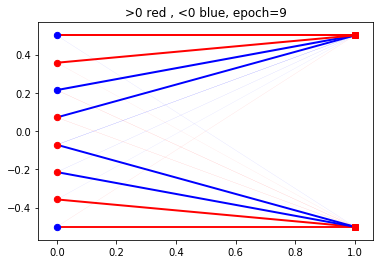

completed epoch  10  with l_rate=  0.3571428571428572


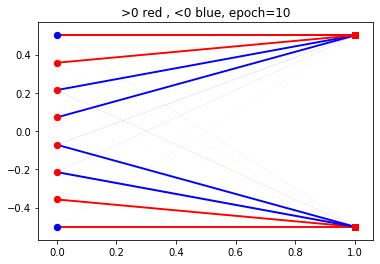

completed epoch  11  with l_rate=  0.3333333333333334


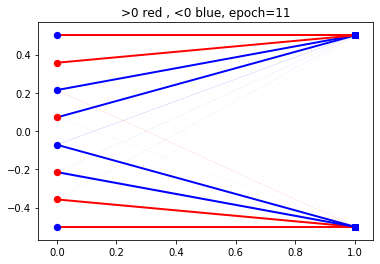

completed epoch  12  with l_rate=  0.3125000000000001


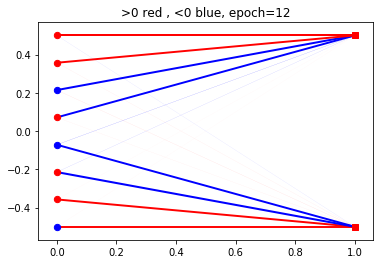

completed epoch  13  with l_rate=  0.29411764705882365


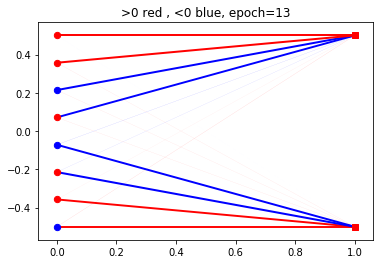

completed epoch  14  with l_rate=  0.2777777777777779


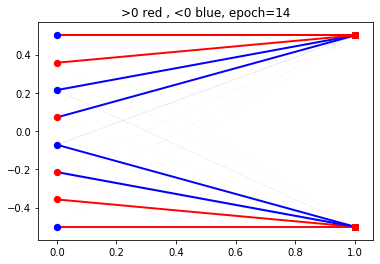

completed epoch  15  with l_rate=  0.2631578947368422


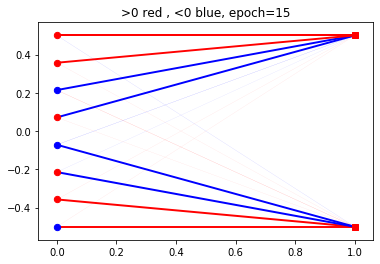

completed epoch  16  with l_rate=  0.2500000000000001


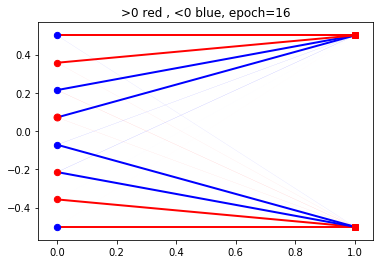

completed epoch  17  with l_rate=  0.2380952380952382


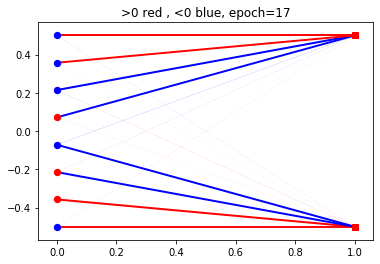

completed epoch  18  with l_rate=  0.22727272727272735


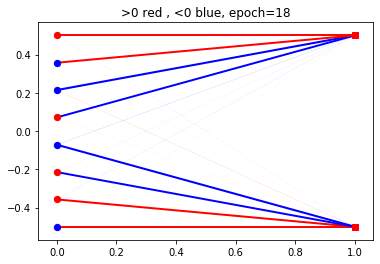

completed epoch  19  with l_rate=  0.21739130434782616


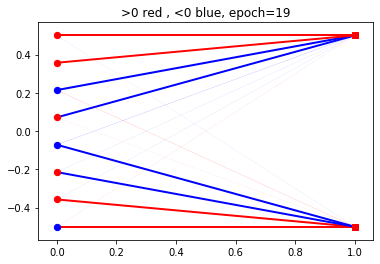

completed epoch  20  with l_rate=  0.20833333333333343


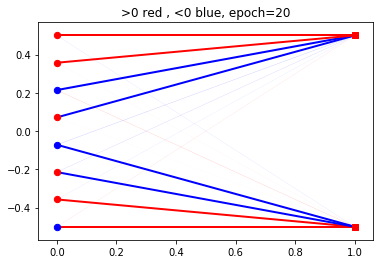

In [10]:
plotgraph(0)

l_rate = 1.0

mini, m = 500, 0
max_epoch = 20

for epoch in range(1,1+max_epoch): # Training the RBM
    l_rate_m = l_rate/mini
    for k in range(N):
        if m==0:
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
        h = activate(v[k],w,b)
        vf = activate(h,w.T,a)
        hf = activate(vf,w,b)
             
        v_data += v[k]
        v_model += vf
        h_data += h 
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model += np.outer(vf.T,hf)
        
        m += 1
        
        if m==mini:
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            if epoch<=2 and k<=mini:
                print('--------- epoch =', epoch, ' k=', k, ' m=', m)
                print('dw =', dw)
                print('da =', da)
                print('db =', db)
            w = w + dw
            a = a + da
            b = b + db
            m = 0
    
    print('completed epoch ', epoch, ' with l_rate= ', l_rate)
    
    np.random.shuffle(v)
    l_rate = l_rate /(0.2*l_rate+1)
    plotgraph(epoch) 

In [11]:
v1 = np.zeros_like(v0)

for k in range(N): # Denoising prcedure using learned parameters
    h = activate(v0[k],w,b)
    v1[k] = activate(h,w.T,a)

diff = (v1 - v0)/2

str0 = 'M'+str(M)+'-mini'+str(mini)+fname

np.savetxt('fant-'+str0, (v1+1)/2, fmt='%d', delimiter=',')
np.savetxt('diff-'+str0, diff    , fmt='%d', delimiter=',')

for k in range(10): # Verifying the results of denoising procedures 
    vec0 = ((v0[k]+1)/2).astype(int)
    vec1 = ((v1[k]+1)/2).astype(int)
    is0 = (vec1==case[0]).all()
    is1 = (vec1==case[1]).all()
    is2 = (vec1==case[2]).all()
    is3 = (vec1==case[3]).all()
    print(vec0,vec1,(is0 or is1 or is2 or is3))   

[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 0] False
[0 0 1 1 0 0 1 1] [1 0 1 1 0 0 1 1] False
[0 0 1 1 0 1 0 0] [0 1 1 1 1 0 0 0] False
[1 0 1 1 0 1 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 1 1 0 0] [0 0 0 1 0 1 0 0] False
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0] True
[1 1 0 0 0 0 1 0] [1 0 0 0 0 0 1 1] False
[1 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 0] False
[0 1 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 0 0 0] False


## 1/2 - Introduce a lower "temperature"  and check if it works properly

In [12]:
random.seed(12345)

def activate(v_in, wei, bias, beta=1, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + exp(-beta*act)) # Introducing in the sigmoid function temperature dependence through beta factor 
    n = np.shape(act)
    v_out = -np.ones(n, dtype=int)
    v_out[np.random.random_sample(n)<prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('output=', v_out)
    return v_out


beta_val = [1, 1.2, 1.5, 2, 2.1, 2.2, 10] # Setting different values of temperature

for beta in beta_val:
    
    random.seed(12345)
    k = 0
    activate(v[k],w,b)

    l_rate = 1.0

    mini, m = 500, 0
    max_epoch = 20

    for epoch in range(1,1+max_epoch):
        l_rate_m = l_rate/mini
        for k in range(N):
            if m==0:
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            h = activate(v[k],w,b)
            vf = activate(h,w.T,a)
            hf = activate(vf,w,b)

            v_data += v[k]
            v_model += vf
            h_data += h 
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model += np.outer(vf.T,hf)

            m += 1

            if m==mini:
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                w = w + dw
                a = a + da
                b = b + db
                m = 0



        np.random.shuffle(v)
        l_rate = l_rate /(0.2*l_rate+1)
        

    v1 = np.zeros_like(v0)

    for k in range(N):
        h = activate(v0[k],w,b, beta)
        v1[k] = activate(h,w.T,a, beta)

    right_guess = 0
    for k in range(int(N)):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        if (is0 or is1 or is2 or is3)==True:
            right_guess += 1

    print("For beta=", beta, " the percentage of correctly denoised sample is ", 100*right_guess/(N),"%", "\n")
        

For beta= 1  the percentage of correctly denoised sample is  43.06 % 

For beta= 1.2  the percentage of correctly denoised sample is  57.07 % 

For beta= 1.5  the percentage of correctly denoised sample is  74.28 % 

For beta= 2  the percentage of correctly denoised sample is  90.64 % 

For beta= 2.1  the percentage of correctly denoised sample is  93.01 % 

For beta= 2.2  the percentage of correctly denoised sample is  93.84 % 

For beta= 10  the percentage of correctly denoised sample is  100.0 % 



## 3 - Introduce more states 

### 3.1 - Introduce fifth layer

In [13]:
N = 10000 # number of data
C = 5 # possible different cases
Z = 2 # block size
L = 4*Z # size of each data point
random.seed(12345)

q = 0.1

y = [0]*N
x = [[0]*L for j in range(N)]
v0 = [0]*Z
v1 = [1]*Z
case = (v1 + v0 + v1 + v0,
        v0 + v1 + v1 + v0,
        v1 + v0 + v0 + v1,
        v0 + v1 + v0 + v1,
        v1 + v1 + v1 + v1)

for c in range(C):
    print('"', c , '"', *case[c], sep = "")
    
print("\n")
    
for i in range(N):
    y[i] = random.randint(0,4)
    x[i][:] = case[y[i]]
    for j in range(L):
        if random.random()<0.1:
            x[i][j] = 1-x[i][j]
            
for i in range(10):
    print('"', y[i] , '"', *x[i], sep = "")

"0"11001100
"1"00111100
"2"11000011
"3"00110011
"4"11111111


"3"00110011
"3"00110011
"4"11111011
"3"10110111
"4"11111101
"3"00110010
"1"00011101
"0"10001100
"0"10001100
"0"10001100


In [14]:
data = np.array(x).reshape(N,L)

In [15]:
v = 2*data - 1 # convert 0,1 to -1,1 
v0 = np.zeros_like(v)
v0[:] = v[:]
for k in range(10):
    print(data[k],v[k])

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[1 1 1 1 1 0 1 1] [ 1  1  1  1  1 -1  1  1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[1 1 1 1 1 1 0 1] [ 1  1  1  1  1  1 -1  1]
[0 0 1 1 0 0 1 0] [-1 -1  1  1 -1 -1  1 -1]
[0 0 0 1 1 1 0 1] [-1 -1 -1  1  1  1 -1  1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]


In [16]:
np.random.seed(12342)

M = 2 # M =1,2,3,4,8 vary M to see results for different hidden layers number

sigma = np.sqrt(4. / float(L+M))

w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

print(w)
print(a)
print(b)

w0, a0, b0 = w, a, b

[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
[0. 0.]


In [17]:
k = 0
activate(v[k],w,b,info=True)

input= [-1 -1  1  1 -1 -1  1  1]
act= [-1.4184683   0.61989888]
prob= [0.19490182 0.65019555]
output= [-1  1]


array([-1,  1])

In [18]:
random.seed(12345)

beta_val = [10,100]

for beta in beta_val:
    
    random.seed(12345)
    k = 0
    activate(v[k],w,b)

    l_rate = 1.0

    mini, m = 500, 0
    max_epoch = 20

    for epoch in range(1,1+max_epoch):
        l_rate_m = l_rate/mini
        for k in range(N):
            if m==0:
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            h = activate(v[k],w,b)
            vf = activate(h,w.T,a)
            hf = activate(vf,w,b)

            v_data += v[k]
            v_model += vf
            h_data += h 
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model += np.outer(vf.T,hf)

            m += 1

            if m==mini:
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                w = w + dw
                a = a + da
                b = b + db
                m = 0



        np.random.shuffle(v)
        l_rate = l_rate /(0.2*l_rate+1)
        

    v1 = np.zeros_like(v0)

    for k in range(N):
        h = activate(v0[k],w,b, beta)
        v1[k] = activate(h,w.T,a, beta)

    right_guess = 0
    for k in range(int(N)):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        is4 = (vec1==case[4]).all()
        if (is0 or is1 or is2 or is3 or is4)==True:
            right_guess += 1

    print("For beta=", beta, " the percentage of correctly denoised sample is ", 100*right_guess/(N),"%", "\n")

For beta= 10  the percentage of correctly denoised sample is  94.27 % 



/home/michelepuppin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


For beta= 100  the percentage of correctly denoised sample is  100.0 % 



The minimum number of hidden layer is still 2.

### 3.2 - Introduce sixth layer

In [19]:
N = 10000 # number of data
C = 6 # possible different cases
Z = 2 # block size
L = 4*Z # size of each data point
random.seed(12345)

q = 0.1

y = [0]*N
x = [[0]*L for j in range(N)]
v0 = [0]*Z
v1 = [1]*Z
v3 = [1,0]
case = (v1 + v0 + v1 + v0,
        v0 + v1 + v1 + v0,
        v1 + v0 + v0 + v1,
        v0 + v1 + v0 + v1,
        v1 + v1 + v1 + v1,
        v3 + v3 + v3 + v0)

for c in range(C):
    print('"', c , '"', *case[c], sep = "")
    
print("\n")
    
for i in range(N):
    y[i] = random.randint(0,5)
    x[i][:] = case[y[i]]
    for j in range(L):
        if random.random()<0.1:
            x[i][j] = 1-x[i][j]
            
for i in range(10):
    print('"', y[i] , '"', *x[i], sep = "")

"0"11001100
"1"00111100
"2"11000011
"3"00110011
"4"11111111
"5"10101000


"3"00110011
"3"00110011
"4"11111011
"5"11101010
"5"10101000
"3"00110010
"1"00011101
"0"10001100
"0"10001100
"5"10001000


In [20]:
data = np.array(x).reshape(N,L)

In [21]:
v = 2*data - 1 # convert 0,1 to -1,1 
v0 = np.zeros_like(v)
v0[:] = v[:]
for k in range(10):
    print(data[k],v[k])

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[1 1 1 1 1 0 1 1] [ 1  1  1  1  1 -1  1  1]
[1 1 1 0 1 0 1 0] [ 1  1  1 -1  1 -1  1 -1]
[1 0 1 0 1 0 0 0] [ 1 -1  1 -1  1 -1 -1 -1]
[0 0 1 1 0 0 1 0] [-1 -1  1  1 -1 -1  1 -1]
[0 0 0 1 1 1 0 1] [-1 -1 -1  1  1  1 -1  1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]
[1 0 0 0 1 0 0 0] [ 1 -1 -1 -1  1 -1 -1 -1]


In [22]:
np.random.seed(12342)

M = 2 # M =1,2,3,4,8 vary M to see results for different hidden layers number

sigma = np.sqrt(4. / float(L+M))

w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

print(w)
print(a)
print(b)

w0, a0, b0 = w, a, b

[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
[0. 0.]


In [23]:
k = 0
activate(v[k],w,b,info=True)

input= [-1 -1  1  1 -1 -1  1  1]
act= [-1.4184683   0.61989888]
prob= [0.19490182 0.65019555]
output= [-1  1]


array([-1,  1])

In [24]:
random.seed(12345)

beta_val = [10,100]

for beta in beta_val:
    
    random.seed(12345)
    k = 0
    activate(v[k],w,b)

    l_rate = 1.0

    mini, m = 500, 0
    max_epoch = 20

    for epoch in range(1,1+max_epoch):
        l_rate_m = l_rate/mini
        for k in range(N):
            if m==0:
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            h = activate(v[k],w,b)
            vf = activate(h,w.T,a)
            hf = activate(vf,w,b)

            v_data += v[k]
            v_model += vf
            h_data += h 
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model += np.outer(vf.T,hf)

            m += 1

            if m==mini:
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                w = w + dw
                a = a + da
                b = b + db
                m = 0



        np.random.shuffle(v)
        l_rate = l_rate /(0.2*l_rate+1)
        

    v1 = np.zeros_like(v0)

    for k in range(N):
        h = activate(v0[k],w,b, beta)
        v1[k] = activate(h,w.T,a, beta)

    right_guess = 0
    for k in range(int(N)):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        is4 = (vec1==case[4]).all()
        is5 = (vec1==case[5]).all()
        if (is0 or is1 or is2 or is3 or is4 or is5)==True:
            right_guess += 1

    print("For beta=", beta, " the percentage of correctly denoised sample is ", 100*right_guess/(N),"%", "\n")

For $eta$= 10  the percentage of correctly denoised sample is  78.82 % 



/home/michelepuppin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


For $eta$= 100  the percentage of correctly denoised sample is  100.0 % 



Again the minimum number of hidden layer is still 2.

## 4 - Repeat the whole procedure with different value of $q$ and $Z$

In [25]:
Z_val = [3,4] # Defining different values of Z
q_val = [0.1,0.2,0.3] # Defining different values of q

In [26]:
for Z in Z_val:
    for q in q_val:    
        random.seed(12345)

        N = 10000 # number of data
        C = 6 # possible different cases
        L = 4*Z # size of each data point

        y = [0]*N
        x = [[0]*L for j in range(N)]
        v0 = [0]*Z
        v1 = [1]*Z
        v3 = [1]+[0]*(Z-1)
        case = (v1 + v0 + v1 + v0,
                v0 + v1 + v1 + v0,
                v1 + v0 + v0 + v1,
                v0 + v1 + v0 + v1,
                v1 + v1 + v1 + v1,
                v3 + v3 + v3 + v0)

        for i in range(N):
            y[i] = random.randint(0,5)
            x[i][:] = case[y[i]]
            for j in range(L):
                if random.random()<q:
                    x[i][j] = 1-x[i][j]

        data = np.array(x).reshape(N,L)

        v = 2*data - 1 # convert 0,1 to -1,1 
        v0 = np.zeros_like(v)
        v0[:] = v[:]

        M = 2

        sigma = np.sqrt(4. / float(L+M))

        w = sigma * (2*np.random.rand(L,M) - 1)
        a = sigma * (2*np.random.rand(L) - 1)
        b = np.zeros(M)

        w0, a0, b0 = w, a, b

        beta_val = [10]

        for beta in beta_val:

            random.seed(12345)
            k = 0
            activate(v[k],w,b)

            l_rate = 1.0

            mini, m = 500, 0
            max_epoch = 20

            for epoch in range(1,1+max_epoch):
                l_rate_m = l_rate/mini
                for k in range(N):
                    if m==0:
                        v_data, v_model = np.zeros(L), np.zeros(L)
                        h_data, h_model = np.zeros(M), np.zeros(M)
                        vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
                    h = activate(v[k],w,b)
                    vf = activate(h,w.T,a)
                    hf = activate(vf,w,b)

                    v_data += v[k]
                    v_model += vf
                    h_data += h 
                    h_model += hf
                    vh_data += np.outer(v[k].T,h)
                    vh_model += np.outer(vf.T,hf)

                    m += 1

                    if m==mini:
                        dw = l_rate_m*(vh_data - vh_model)
                        da = l_rate_m*(v_data - v_model)
                        db = l_rate_m*(h_data - h_model)
                        w = w + dw
                        a = a + da
                        b = b + db
                        m = 0

                np.random.shuffle(v)
                l_rate = l_rate /(0.2*l_rate+1)

            v1 = np.zeros_like(v0)

            for k in range(N):
                h = activate(v0[k],w,b, beta)
                v1[k] = activate(h,w.T,a, beta)

            right_guess = 0
            for k in range(int(N)):
                vec0 = ((v0[k]+1)/2).astype(int)
                vec1 = ((v1[k]+1)/2).astype(int)
                is0 = (vec1==case[0]).all()
                is1 = (vec1==case[1]).all()
                is2 = (vec1==case[2]).all()
                is3 = (vec1==case[3]).all()
                is4 = (vec1==case[4]).all()
                is5 = (vec1==case[5]).all()
                if (is0 or is1 or is2 or is3 or is4 or is5)==True:
                    right_guess += 1

            print("For beta=", beta, "with Z=", Z, " and q=", q, " the percentage of correctly denoised sample is ", 100*right_guess/(N),"%", "\n")

For beta= 10 with Z= 3  and q= 0.1  the percentage of correctly denoised sample is  50.53 % 

For beta= 10 with Z= 3  and q= 0.2  the percentage of correctly denoised sample is  82.55 % 

For beta= 10 with Z= 3  and q= 0.3  the percentage of correctly denoised sample is  56.18 % 

For beta= 10 with Z= 4  and q= 0.1  the percentage of correctly denoised sample is  39.5 % 

For beta= 10 with Z= 4  and q= 0.2  the percentage of correctly denoised sample is  52.89 % 

For beta= 10 with Z= 4  and q= 0.3  the percentage of correctly denoised sample is  82.38 % 

